### Imports

In [1]:
from src.digit_functions import loadDigits
from Models import PixelModel

import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"{torch.__version__}")
print(f"{np.__version__}")
print(f"{mpl.__version__}")
print(f"{device}")

2.0.0+cpu
1.24.2
3.7.1
cpu


# Pixel Based Sudoku Solver Model

### Load Feature Transformed Training Digits

In [2]:
SRC = "./data/digits/transformed/pixel/"

transformedDigits = loadDigits(SRC)

(+) Reading data from .npy file...
(+) Digit loading finished


### Training

In [3]:
X_TRAIN_TENSOR = torch.tensor(transformedDigits[0][0], dtype=torch.float32)
Y_TRAIN_TENSOR = torch.tensor(transformedDigits[0][1] - 1, dtype=torch.long)
print(X_TRAIN_TENSOR.shape)
print(Y_TRAIN_TENSOR.shape)
X_TEST_TENSOR = torch.tensor(transformedDigits[1][0], dtype=torch.float32)
Y_TEST_TENSOR = torch.tensor(transformedDigits[1][1] - 1, dtype=torch.long)
print(X_TEST_TENSOR.shape)
print(Y_TEST_TENSOR.shape)

torch.Size([1496250, 1600])
torch.Size([1496250])
torch.Size([78750, 1600])
torch.Size([78750])


In [4]:
BATCH_SIZE = 256
tensorDataset = torch.utils.data.TensorDataset(X_TRAIN_TENSOR, Y_TRAIN_TENSOR)
dataloader = torch.utils.data.DataLoader(tensorDataset, BATCH_SIZE, shuffle=True)

In [5]:
model = PixelModel()
model = model.to(device)
lossfn = torch.nn.CrossEntropyLoss()

In [7]:
LEARNING_RATE = 0.0001
BETAS = (0.9, 0.99)
EPS = 1e-5
optimizer = torch.optim.Adam(model.parameters(), LEARNING_RATE, BETAS, EPS)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.6, total_iters=8)

#### 1. Training

In [8]:
EPOCHS = 10

trainLosses = []
testLosses = []
trainAccuracies = []
testAccuracies = []

for epoch in range(EPOCHS):

    model.train()

    for x_batch, y_batch in dataloader:

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        _Y = model(x_batch)
        loss = lossfn(_Y, y_batch)

        loss.backward()

        optimizer.step()

    model.eval()

    _Y = model(X_TRAIN_TENSOR)
    trainLoss = lossfn(_Y, Y_TRAIN_TENSOR).item()
    trainLosses.append(trainLoss)
    trainAccuracy = accuracy_score(Y_TRAIN_TENSOR.detach().cpu().numpy(), _Y.detach().cpu().argmax(dim=1).numpy())
    trainAccuracies.append(trainAccuracy)

    _Y = model(X_TEST_TENSOR)
    testLoss = lossfn(_Y, Y_TEST_TENSOR).item()
    testLosses.append(testLoss)
    testAccuracy = accuracy_score(Y_TEST_TENSOR.detach().cpu().numpy(), _Y.detach().cpu().argmax(dim=1).numpy())
    testAccuracies.append(testAccuracy)

    scheduler.step()

    if epoch % 3 == 0:
        print(f"Epoch: {epoch}:")
        print(f"\tLosses: {trainLosses[-1]} - {testLosses[-1]}")
        print(f"\tAccuracies: {trainAccuracies[-1]} - {testAccuracies[-1]}")
        print(f"\tCurrent learning rate: {optimizer.param_groups[0]['lr']}")

Epoch: 0:
	Losses: 0.22516608238220215 - 0.22661155462265015
	Accuracies: 0.948828738512949 - 0.9484317460317461
	Current learning rate: 9.5e-05
Epoch: 3:
	Losses: 0.010679841041564941 - 0.011153503321111202
	Accuracies: 0.9991311612364244 - 0.9989714285714286
	Current learning rate: 8e-05
Epoch: 6:
	Losses: 0.0026359567418694496 - 0.002704627811908722
	Accuracies: 0.9997974937343358 - 0.9998603174603174
	Current learning rate: 6.500000000000001e-05
Epoch: 9:
	Losses: 0.00027254701126366854 - 0.0002978638221975416
	Accuracies: 1.0 - 1.0
	Current learning rate: 6e-05


In [9]:
print(trainLosses)
print(testLosses)
print(trainAccuracies)
print(testAccuracies)

[0.22516608238220215, 0.05364212766289711, 0.020615434274077415, 0.010679841041564941, 0.0035845444072037935, 0.0017231341917067766, 0.0026359567418694496, 0.0006963798659853637, 0.00034152151783928275, 0.00027254701126366854]
[0.22661155462265015, 0.05464708432555199, 0.021552950143814087, 0.011153503321111202, 0.00373630179092288, 0.0018398604588583112, 0.002704627811908722, 0.0007645391160622239, 0.00036520263529382646, 0.0002978638221975416]
[0.948828738512949, 0.9896628237259816, 0.9960962406015038, 0.9991311612364244, 0.9998743525480368, 0.999987969924812, 0.9997974937343358, 1.0, 1.0, 1.0]
[0.9484317460317461, 0.9890031746031746, 0.9954285714285714, 0.9989714285714286, 0.9998730158730159, 0.9999873015873015, 0.9998603174603174, 1.0, 1.0, 1.0]


Text(0.5, 1.0, 'Accuracies')

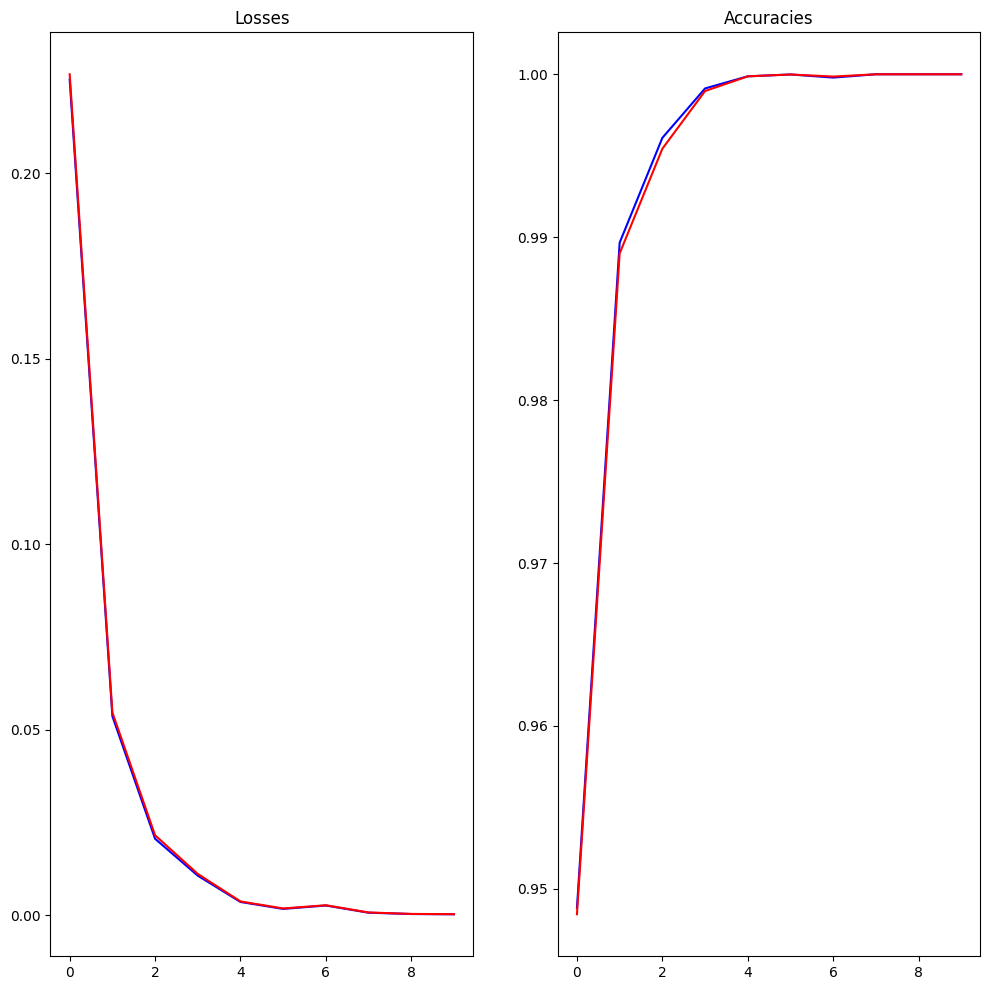

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 12))
axs = axs.flatten()

axs[0].plot(np.arange(0, EPOCHS, 1), trainLosses, color="blue")
axs[0].plot(np.arange(0, EPOCHS, 1), testLosses, color="red")
axs[0].set_title("Losses")

axs[1].plot(np.arange(0, EPOCHS, 1), trainAccuracies, color="blue")
axs[1].plot(np.arange(0, EPOCHS, 1), testAccuracies, color="red")
axs[1].set_title("Accuracies")

In [11]:
MODEL_DST = "./models/"
MODEL_NAME = "pixel.pth"

torch.save(model, MODEL_DST + MODEL_NAME)